In [1]:
#!/usr/bin/env python3
#SBATCH --cpus=1
#SBATCH --gres=gpu:1
#SBATCH --mem=20GB
#SBATCH --mail-type=ALL
#SBATCH --mail-user=abstreik
#SBATCH --time=45:00:00

In [2]:
import sys 
sys.path.append('../helper')
import pandas as pd
import torch.nn as nn
import random
from torch.optim import Adam
from torch.utils.data import DataLoader,TensorDataset
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import RotationMatrix
import time
from sklearn.model_selection import KFold
# from tqdm import tqdm_notebook as tqdm
tqdm = lambda x: x

In [3]:
points = pd.read_csv("../data/rotated_points_angle.csv")

In [4]:
class Net(nn.Module):
    def __init__(self, n_hidden=None):
        super().__init__()
        hidden_nodes = 50 if n_hidden is None else n_hidden
        self.ff = nn.Sequential(
            nn.Linear(1, hidden_nodes),
            nn.Sigmoid(),
            nn.Linear(hidden_nodes, 1)
        )
    
    def forward(self, x_batch):
        return self.ff(x_batch)

## Check if model can learn sine function

In [5]:
def train_sin():
    random.seed(234)
    model = Net()
    opt = Adam(model.parameters())
    model.train()
    for i in tqdm(range(300000)):
        alpha = random.uniform(0, 2*math.pi)
        pred = model(torch.Tensor([alpha]))
        y_true = math.sin(alpha)
        opt.zero_grad()
        loss = (pred - y_true) ** 2
        loss.backward()
        opt.step()
    return model

In [6]:
def plot_sin_model(model):
    test = np.linspace(0, 2*math.pi, 100)
    model.eval()
    pred = model(torch.Tensor(np.matrix(test).transpose()))
    plt.plot(test, np.sin(test))
    plt.plot(test, pred.detach().numpy())
    plt.show()

In [7]:
def plot_matrix_nets(nets):
    test = np.linspace(0, 2*math.pi, 100)
    for model in nets:
        model.eval()
    fig, ax = plt.subplots(2, 2)
    ax[0, 0].plot(test, np.cos(test))
    ax[0, 0].plot(test, nets[0](torch.Tensor(np.matrix(test).transpose())).detach().numpy())
    ax[0, 1].plot(test, -np.sin(test))
    ax[0, 1].plot(test, nets[1](torch.Tensor(np.matrix(test).transpose())).detach().numpy())
    ax[1, 0].plot(test, np.sin(test))
    ax[1, 0].plot(test, nets[2](torch.Tensor(np.matrix(test).transpose())).detach().numpy())
    ax[1, 1].plot(test, np.cos(test))
    ax[1, 1].plot(test, nets[3](torch.Tensor(np.matrix(test).transpose())).detach().numpy())
    plt.show()

In [8]:
# plot_sin_model(train_sin())

# Train nets for matrix

In [5]:
def get_loader(data, shuffle=True):
    X = torch.FloatTensor(data[["x1", "y1", "alpha"]].values)
    y = torch.FloatTensor(data[["x2", "y2"]].values)
    torch_data = TensorDataset(X, y)
    loader = DataLoader(torch_data, batch_size=5, shuffle=shuffle)
    return loader

In [6]:
def l2_loss(y_pred, y_true, rotation_matrix):
    return (y_pred[0] - y_true[0]) ** 2 + (y_pred[1] - y_true[1]) ** 2

In [7]:
def calc_pred_loss(x_batch, y_batch, nets, loss_fn):
    alphas = x_batch[:, [2]]
    matrix_entries = [model(alphas) for model in nets]
    loss = 0
    preds = []
    for i in range(len(alphas)):
        predx = matrix_entries[0][i] * x_batch[i][0] + matrix_entries[1][i] * x_batch[i][1]
        predy = matrix_entries[2][i] * x_batch[i][0] + matrix_entries[3][i] * x_batch[i][1]
        loss += loss_fn((predx, predy), y_batch[i], [[matrix_entries[0][i], matrix_entries[1][i]], [matrix_entries[2][i], matrix_entries[3][i]]])
        preds.append((predx.item(), predy.item()))
    loss /= len(alphas)
    return {"loss": loss, "preds": preds}

In [8]:
def calc_loss(x_batch, y_batch, nets, loss_fn):
    return calc_pred_loss(x_batch, y_batch, nets, loss_fn)["loss"]

In [9]:
test_data = pd.read_csv("../data/test.csv")
# test_data = test_data[test_data.index % 20 == 0]
test_loader = get_loader(test_data, shuffle=False)

In [10]:
def test(net_ensemble, loss_fn=l2_loss, visualizePreds=False):
    test_preds = []
    test_true = []
    all_model_preds = []
    avg_test_loss = 0.0
    for nets in net_ensemble:
        model_preds = []
        for model in nets:
            model.eval()
        for x_batch, y_batch in test_loader:
            result = calc_pred_loss(x_batch, y_batch, nets, loss_fn)
            model_preds += result["preds"]
            avg_test_loss += result["loss"]
            test_true += list(y_batch)
        all_model_preds.append(model_preds)
        if visualizePreds:
            print("model preds:")
            plot_predictions(model_preds)
    avg_test_loss /= len(test_loader) * len(net_ensemble)
    for i in range(len(all_model_preds[0])):
        predx = 0
        predy = 0
        for model_preds in all_model_preds:
            predx += model_preds[i][0]
            predy += model_preds[i][1]
        predx /= len(all_model_preds)
        predy /= len(all_model_preds)
        test_preds.append((predx, predy))
    if visualizePreds:
        print("total preds:")
        plot_predictions(test_preds)
    test_loss = 0
    for y_pred, y_true in zip(test_preds, test_true):
        test_loss += loss_fn(y_pred, y_true, [[float('NaN'), float('NaN')], [float('NaN'), float('NaN')]])
    test_loss /= len(test_preds)
    return {"loss": test_loss.item(), "preds": test_preds}

In [11]:
def train(n_points_train_val, loss_fn, includeTests=False, prints=False, lastTrainResult=None, nEpochs=None, minEpochs=8000, hidden_nodes=None):
    torch.manual_seed(0)
    train_val_points = points.head(n_points_train_val)
    n_folds = min(n_points_train_val, 10)
    fold_indices = [(range(n_points_train_val), range(n_points_train_val))]
    if n_folds > 1:
        kf = KFold(n_folds, random_state=0)
        fold_indices = kf.split(train_val_points)

    train_loader = []
    val_loader = []
    for train_index, val_index in fold_indices:
        train_loader.append(get_loader(points.loc[train_index]))
        val_loader.append(get_loader(points.loc[val_index]))
    
    nets = [[Net(n_hidden=hidden_nodes) for _ in range(4)] for _ in range(n_folds)] if lastTrainResult is None else lastTrainResult["nets"]
    opts = []
    if lastTrainResult is None:
        for matrixnets in nets:
            optrow = []
            for model in matrixnets:
                optrow.append(Adam(model.parameters()))
            opts.append(optrow)
    else:
        opts = lastTrainResult["opts"]
    val_losses = [] if lastTrainResult is None else lastTrainResult["val_loss"]
    train_losses = [] if lastTrainResult is None else lastTrainResult["train_loss"]
    test_losses = [] if lastTrainResult is None else lastTrainResult["test_loss"]
    best_test_preds = None if lastTrainResult is None else lastTrainResult["best_test_preds"]
    epochs = [] if lastTrainResult is None else lastTrainResult["epochs"]
    epoch = 0 if lastTrainResult is None else (epochs[-1] + 1)
    start_epoch = epoch
    epochs_per_validation = 500#100 if n_points_train_val > 10 else (10 if n_points_train_val > 5 else 3)
    while True:
        epoch_val_loss = 0
        epoch_train_loss = 0
        validate = (epoch % epochs_per_validation == 0)
        for fold in range(n_folds):
            # training
            for model in nets[fold]:
                model.train()
            for x_batch, y_batch in train_loader[fold]:
                loss = calc_loss(x_batch, y_batch, nets[fold], loss_fn)
                for opt in opts[fold]:
                    opt.zero_grad()
                loss.backward()
                for opt in opts[fold]:
                    opt.step()
            # validation
            if validate:
                for model in nets[fold]:
                    model.eval()
                val_loss = 0
                train_loss = 0
                for x_batch, y_batch in val_loader[fold]:
                    val_loss += calc_loss(x_batch, y_batch, nets[fold], loss_fn)
                for x_batch, y_batch in train_loader[fold]:
                    train_loss += calc_loss(x_batch, y_batch, nets[fold], loss_fn)
                val_loss /= len(val_loader[fold])
                train_loss /= len(train_loader[fold])
                epoch_val_loss += val_loss
                epoch_train_loss += train_loss

        if validate:
            epochs.append(epoch)
            epoch_val_loss /= n_folds
            epoch_train_loss /= n_folds
            val_losses.append(epoch_val_loss.item())
            train_losses.append(epoch_train_loss.item())
            if includeTests:
                test_result = test(nets, visualizePreds=False)#(epoch%1000 == 0))
                test_losses.append(test_result["loss"])
                if len(val_losses) > 1 and (best_test_preds is None or val_losses[-1] < min(val_losses[1:-1])):
                    best_test_preds = test_result["preds"]
        if prints and epoch % 500 == 0:
            print("Epoch {}:\tTrain {}\tVal {}\tTest {}".format(epoch, train_losses[-1], val_losses[-1], test_losses[-1]))
        epoch += 1
        reference_loss_index = 1000 // epochs_per_validation
        if (nEpochs is None and epoch > max(n_points_train_val * 200, minEpochs) and val_losses[-1] >= val_losses[-reference_loss_index]) or (nEpochs is not None and epoch - start_epoch > nEpochs):
            break
    
    return {"nets": nets, 
            "opts": opts,
            "train_loss": train_losses, 
            "val_loss": val_losses, 
            "test_loss": test_losses, 
            "best_test_preds": best_test_preds,
            "epochs": epochs
           }

In [12]:
def visualize_train(train_results, keys=["train_loss", "val_loss", "test_loss"]):
    for i, train_result in enumerate(train_results):
        for key in keys:
            plt.plot(train_result["epochs"], train_result[key], label='{}_{}'.format(key, i))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

In [13]:
def plot_predictions(preds):
    plt.figure()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    for i, pred in enumerate(preds):
        test_point = test_data.iloc[i]
        plt.plot([test_point["x1"], test_point["x2"]], [test_point["y1"], test_point["y2"]], color="green", linewidth=0.5)
        plt.plot([pred[0], test_point["x2"]], [pred[1], test_point["y2"]], color="red", linewidth=0.5)

    plt.show()

## Train with n points until convergence using l2_loss

### Compare different numbers of hidden nodes

In [15]:
n_points_train_val = 10

In [18]:
if False:
    results_hidden_nodes = []
    for n_hidden in [5, 10, 20, 50, 100]:
        print("Start calculation for {} hidden nodes.".format(n_hidden))
        nEpochs = 30000 if n_hidden < 50 else 70000
        train_result = train(n_points_train_val, l2_loss, includeTests=True, prints=True, nEpochs=nEpochs, hidden_nodes=n_hidden)
        del train_result["nets"]
        del train_result["opts"]
        results_hidden_nodes.append([n_hidden, str(train_result)])
    results_hidden_nodes = pd.DataFrame(results_hidden_nodes, columns=["n_hidden", "train_result"])
    results_hidden_nodes.to_csv("results_hidden_nodes.csv", index=False)

In [ ]:
# results_hidden_nodes = pd.read_csv("results_hidden_nodes.csv")

In [ ]:
# results_hidden_nodes["train_result"] = results_hidden_nodes.apply(lambda row: eval(row["train_result"]), axis=1)

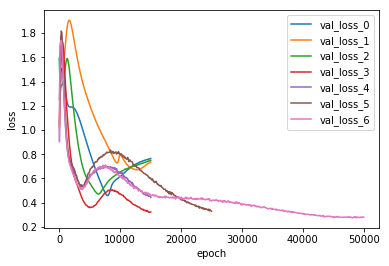

In [129]:
# visualize_train(results_hidden_nodes["train_result"], keys=["val_loss"])
# visualize_train(results_hidden_nodes["train_result"], keys=["val_loss", "test_loss"])

Result: Choose 50 hidden nodes (almost same validation loss with much less epochs)
Difficulty: Validation loss with few data is unreliable

### Calculate for different numbers of points and save results

In [17]:
results_limited_data = []
for n_points_train_val in range(1, 36):
    print("Start calculation for {} points.".format(n_points_train_val))
    train_result = train(n_points_train_val, l2_loss, includeTests=True, prints=True, minEpochs=12000)
    del train_result["nets"]
    del train_result["opts"]
    results_limited_data.append([n_points_train_val, str(train_result)])
    if n_points_train_val >= 20 and n_points_train_val % 5 == 0:
        df = pd.DataFrame(results_limited_data, columns=["n_points_train_val", "train_result"])
        df.to_csv("train_limited_data_results_{}.csv".format(n_points_train_val), index=False)
results_limited_data = pd.DataFrame(results_limited_data, columns=["n_points_train_val", "train_result"])
results_limited_data.to_csv("results_limited_data.csv", index=False)

In [ ]:
# results_limited_data = pd.read_csv("train_limited_data_results_{}.csv", index_col="n_points_train_val")
# results_limited_data["train_result"] = results.apply(lambda row: eval(row["train_result"]), axis=1)

## Add different loss functions

In [159]:
# Choose a specific number of points to further experiment with
n_points_train_val = 10
train_result = results_limited_data["train_result"][n_points_train_val]

In [156]:
def norm_loss(y_pred, y_true, rotation_matrix):
    return (l2_loss(y_pred, (0,0), np.zeros((2,2))) - 1) ** 2

In [157]:
def det_loss(y_pred, y_true, rotation_matrix):
    det = rotation_matrix[0][0] * rotation_matrix[1][1] - rotation_matrix[0][1] * rotation_matrix[1][0]
    return (det - 1) ** 2

In [158]:
# first weight is for l2_loss, second weight for det_loss, third for norm loss
def get_mixed_lossfn(weigths):
    def mixed_loss(y_pred, y_true, rotation_matrix):
        l0 = l2_loss(y_pred, y_true, rotation_matrix)
        l1 = det_loss(y_pred, y_true, rotation_matrix)
        l2 = norm_loss(y_pred, y_true, rotation_matrix)
        return weigths[0] * l0 + weigths[1] * l1 + weigths[2] * l2
    return mixed_loss

In [19]:
train_result_mixed = train(n_points_train_val, get_mixed_lossfn((1, 0, 0)), includeTests=True, prints=True, nEpochs=30000)

In [ ]:
train_result_mixed = train(n_points_train_val, get_mixed_lossfn((1, 2, 0.2)), includeTests=True, prints=True, nEpochs=30000)

In [ ]:
train_result_mixed = train(n_points_train_val, get_mixed_lossfn((1, 0.2, 0.1)), includeTests=True, prints=True, nEpochs=30000)

In [ ]:
#visualize_train([train_result, train_result_mixed])

Results: 
(1, 2, 0.2) is better, converges to 0.08 test loss
(1, 2, 8) is worse
(1, 4, 0.2) really bad

# NEXT: Try different weights, try dynamically changing loss functions